In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
from gym import wrappers
%matplotlib inline

/home/am/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class PolicyNetwork(object):
    def __init__(self, N_SIZE, h=200, gamma=0.99, eta=1e-3, decay=0.99, save_path = 'models1/pong.ckpt' ):

        self.gamma = gamma
        self.save_path = save_path
        
        
        # Placeholders for passing state....
        self.tf_x = tf.placeholder(dtype=tf.float32, shape=[None, N_SIZE * N_SIZE], name="tf_x")
        self.tf_y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions], name="tf_y")
        self.tf_epr = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="tf_epr")

        # Weights
        xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1. / N_SIZE, dtype=tf.float32)
        self.W1 = tf.get_variable("W1", [N_SIZE * N_SIZE, h], initializer=xavier_l1)
        xavier_l2 = tf.truncated_normal_initializer(mean=0, stddev=1. / np.sqrt(h), dtype=tf.float32)
        self.W2 = tf.get_variable("W2", [h, n_actions], initializer=xavier_l2)

        # Build Computation
        # tf reward processing (need tf_discounted_epr for policy gradient wizardry)
        tf_discounted_epr = self.tf_discount_rewards(self.tf_epr)
        tf_mean, tf_variance = tf.nn.moments(tf_discounted_epr, [0], shift=None, name="reward_moments")
        tf_discounted_epr -= tf_mean
        tf_discounted_epr /= tf.sqrt(tf_variance + 1e-6)

        # Define Optimizer, compute and apply gradients
        self.tf_aprob = self.tf_policy_forward(self.tf_x)
        loss = tf.losses.log_loss(labels = self.tf_y,
                                      predictions = self.tf_aprob,
                                      weights = tf_discounted_epr)
        optimizer = tf.train.AdamOptimizer()
        self.train_op = optimizer.minimize(loss)         
        
               
        


    def set_session(self, session):
        self.session = session
        self.session.run(tf.global_variables_initializer())
        self.saver = tf.train.Saver()


    def tf_discount_rewards(self, tf_r):  # tf_r ~ [game_steps,1]
        discount_f = lambda a, v: a * self.gamma + v;
        tf_r_reverse = tf.scan(discount_f, tf.reverse(tf_r, [0]))
        tf_discounted_r = tf.reverse(tf_r_reverse, [0])
        return tf_discounted_r

    def tf_policy_forward(self, x): #x ~ [1,D]
         h = tf.matmul(x, self.W1)
         h = tf.nn.relu(h)
         logp = tf.matmul(h, self.W2)
         p = tf.nn.softmax(logp)
         return p

    def update(self, feed):
        return self.session.run(self.train_op, feed)

    def load(self):
        self.saver = tf.train.Saver(tf.global_variables())
        load_was_success = True  # yes, I'm being optimistic
        try:
            save_dir = '/'.join(self.save_path.split('/')[:-1])
            ckpt = tf.train.get_checkpoint_state(save_dir)
            load_path = ckpt.model_checkpoint_path
            print(load_path)
            self.saver.restore(self.session, load_path)
        except:
            print("no saved model to load. starting new session")
            load_was_success = False
        else:
            print("loaded model: {}".format(load_path))
            saver = tf.train.Saver(tf.global_variables())
            episode_number = int(load_path.split('-')[-1])

    def save(self):
        self.saver.save(self.session, self.save_path, global_step=n)
        print("SAVED MODEL #{}".format(n))


    def predict_UP(self,x):
        feed = {self.tf_x: np.reshape(x, (1, -1))}
        aprob = self.session.run(self.tf_aprob, feed);
        return aprob


In [3]:
# downsampling
def preprocess(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1    # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


In [4]:
# Create Game Environment
env_name = "Pong-v0"
env = gym.make(env_name)
env = wrappers.Monitor(env, '/tmp/pong', force=True)
n_actions = env.action_space.n  # Number of possible actions
# Initializing Game and State(t-1), action, reward, state(t)
states, rewards, labels = [], [], []
obs = env.reset()
prev_state = None


running_reward = None
running_rewards = []
reward_sum = 0
n = 0
done = False
n_size = 80
num_episodes = 2500

#Create Agent
agent = PolicyNetwork(n_size)

[2018-07-10 13:48:37,032] Making new env: Pong-v0
[2018-07-10 13:48:37,179] Clearing 26 monitor files from previous run (because force=True was provided)
[2018-07-10 13:48:37,187] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video000000.mp4


models1/pong.ckpt-2500
INFO:tensorflow:Restoring parameters from models1/pong.ckpt-2500


[2018-07-10 13:48:37,938] Restoring parameters from models1/pong.ckpt-2500


loaded model: models1/pong.ckpt-2500


[2018-07-10 13:48:53,406] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video000001.mp4


ep 0: reward: 3.0, mean reward: 3.000000
	ep 1: reward: 5.0
	ep 2: reward: 8.0
	ep 3: reward: -5.0
	ep 4: reward: 4.0
	ep 5: reward: -5.0
	ep 6: reward: 3.0


[2018-07-10 13:50:18,515] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video000008.mp4


	ep 7: reward: 2.0
	ep 8: reward: -6.0
	ep 9: reward: 1.0
ep 10: reward: -6.0, mean reward: 2.715466
	ep 11: reward: -4.0
	ep 12: reward: -2.0
	ep 13: reward: 5.0
	ep 14: reward: 9.0
	ep 15: reward: -2.0
	ep 16: reward: -6.0
	ep 17: reward: 3.0
	ep 18: reward: 5.0
	ep 19: reward: 3.0
ep 20: reward: -3.0, mean reward: 2.533318
	ep 21: reward: 2.0
	ep 22: reward: 4.0
	ep 23: reward: -1.0
	ep 24: reward: 7.0
	ep 25: reward: -3.0


[2018-07-10 13:54:11,972] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video000027.mp4


	ep 26: reward: -3.0
	ep 27: reward: 5.0
	ep 28: reward: 8.0
	ep 29: reward: -5.0
ep 30: reward: 2.0, mean reward: 2.442926
	ep 31: reward: 8.0
	ep 32: reward: 4.0
	ep 33: reward: -3.0
	ep 34: reward: -2.0
	ep 35: reward: 1.0
	ep 36: reward: 1.0
	ep 37: reward: 2.0
	ep 38: reward: 3.0
	ep 39: reward: -4.0
ep 40: reward: -2.0, mean reward: 2.280863
	ep 41: reward: -1.0
	ep 42: reward: 4.0
	ep 43: reward: -2.0
	ep 44: reward: -7.0
	ep 45: reward: 10.0
	ep 46: reward: 1.0
	ep 47: reward: 4.0
	ep 48: reward: -5.0
	ep 49: reward: 7.0
SAVED MODEL #50
ep 50: reward: 2.0, mean reward: 2.189813
	ep 51: reward: -4.0
	ep 52: reward: -6.0
	ep 53: reward: 6.0
	ep 54: reward: 2.0
	ep 55: reward: 3.0
	ep 56: reward: -4.0
	ep 57: reward: 4.0
	ep 58: reward: -2.0
	ep 59: reward: 7.0
ep 60: reward: 4.0, mean reward: 2.081892
	ep 61: reward: 3.0
	ep 62: reward: 8.0


[2018-07-10 14:01:56,303] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video000064.mp4


	ep 63: reward: 2.0
	ep 64: reward: -1.0
	ep 65: reward: -2.0
	ep 66: reward: -4.0
	ep 67: reward: 4.0
	ep 68: reward: 1.0
	ep 69: reward: 6.0
ep 70: reward: 3.0, mean reward: 2.073846
	ep 71: reward: 4.0
	ep 72: reward: -3.0
	ep 73: reward: 2.0
	ep 74: reward: -9.0
	ep 75: reward: 6.0
	ep 76: reward: 1.0
	ep 77: reward: 6.0
	ep 78: reward: -4.0
	ep 79: reward: -2.0
ep 80: reward: -6.0, mean reward: 1.824195
	ep 81: reward: -1.0
	ep 82: reward: 7.0
	ep 83: reward: -5.0
	ep 84: reward: 2.0
	ep 85: reward: 3.0
	ep 86: reward: 7.0
	ep 87: reward: -12.0
	ep 88: reward: -4.0
	ep 89: reward: 3.0
ep 90: reward: -6.0, mean reward: 1.587284
	ep 91: reward: -7.0
	ep 92: reward: -8.0
	ep 93: reward: 4.0
	ep 94: reward: 9.0
	ep 95: reward: -1.0
	ep 96: reward: -9.0
	ep 97: reward: -9.0
	ep 98: reward: -12.0
	ep 99: reward: -2.0
SAVED MODEL #100
ep 100: reward: 2.0, mean reward: 1.119059
	ep 101: reward: 4.0
	ep 102: reward: 4.0
	ep 103: reward: 1.0
	ep 104: reward: -1.0
	ep 105: reward: 3.0
	ep 10

[2018-07-10 14:14:25,098] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video000125.mp4


	ep 124: reward: 5.0
	ep 125: reward: -1.0
	ep 126: reward: 8.0
	ep 127: reward: 3.0
	ep 128: reward: -2.0
	ep 129: reward: 3.0
ep 130: reward: 6.0, mean reward: 1.264871
	ep 131: reward: -9.0
	ep 132: reward: 8.0
	ep 133: reward: 6.0
	ep 134: reward: 6.0
	ep 135: reward: 7.0
	ep 136: reward: 8.0
	ep 137: reward: 3.0
	ep 138: reward: -11.0
	ep 139: reward: 9.0
ep 140: reward: 6.0, mean reward: 1.461757
	ep 141: reward: -1.0
	ep 142: reward: -6.0
	ep 143: reward: -7.0
	ep 144: reward: -2.0
	ep 145: reward: -9.0
	ep 146: reward: 5.0
	ep 147: reward: -8.0
	ep 148: reward: -5.0
	ep 149: reward: 9.0
SAVED MODEL #150
ep 150: reward: 8.0, mean reward: 1.178325
	ep 151: reward: 2.0
	ep 152: reward: -2.0
	ep 153: reward: 7.0
	ep 154: reward: -7.0
	ep 155: reward: -4.0
	ep 156: reward: -8.0
	ep 157: reward: 3.0
	ep 158: reward: 8.0
	ep 159: reward: -5.0
ep 160: reward: -2.0, mean reward: 0.987942
	ep 161: reward: -4.0
	ep 162: reward: -5.0
	ep 163: reward: 6.0
	ep 164: reward: 4.0
	ep 165: rewar

[2018-07-10 14:32:54,216] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video000216.mp4


	ep 215: reward: 5.0
	ep 216: reward: -8.0
	ep 217: reward: -8.0
	ep 218: reward: 1.0
	ep 219: reward: -6.0
ep 220: reward: 8.0, mean reward: 0.475342
	ep 221: reward: 4.0
	ep 222: reward: 7.0
	ep 223: reward: 5.0
	ep 224: reward: -1.0
	ep 225: reward: -6.0
	ep 226: reward: -1.0
	ep 227: reward: -8.0
	ep 228: reward: -3.0
	ep 229: reward: -8.0
ep 230: reward: -4.0, mean reward: 0.275320
	ep 231: reward: -8.0
	ep 232: reward: 1.0
	ep 233: reward: -8.0
	ep 234: reward: 3.0
	ep 235: reward: -10.0
	ep 236: reward: 10.0
	ep 237: reward: 2.0
	ep 238: reward: 3.0
	ep 239: reward: -1.0
ep 240: reward: 6.0, mean reward: 0.238689
	ep 241: reward: 7.0
	ep 242: reward: -6.0
	ep 243: reward: 1.0
	ep 244: reward: 1.0
	ep 245: reward: 5.0
	ep 246: reward: 4.0
	ep 247: reward: -4.0
	ep 248: reward: 2.0
	ep 249: reward: 4.0
SAVED MODEL #250
ep 250: reward: 3.0, mean reward: 0.379547
	ep 251: reward: 11.0
	ep 252: reward: 4.0
	ep 253: reward: 4.0
	ep 254: reward: -6.0
	ep 255: reward: -4.0
	ep 256: rewa

[2018-07-10 14:58:30,924] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video000343.mp4


	ep 342: reward: 4.0
	ep 343: reward: 5.0
	ep 344: reward: 1.0
	ep 345: reward: 4.0
	ep 346: reward: -1.0
	ep 347: reward: -2.0
	ep 348: reward: -3.0
	ep 349: reward: 1.0
SAVED MODEL #350
ep 350: reward: 3.0, mean reward: 0.589401
	ep 351: reward: 5.0
	ep 352: reward: -4.0
	ep 353: reward: -3.0
	ep 354: reward: 1.0
	ep 355: reward: 1.0
	ep 356: reward: 1.0
	ep 357: reward: -3.0
	ep 358: reward: 1.0
	ep 359: reward: -3.0
ep 360: reward: -1.0, mean reward: 0.483370
	ep 361: reward: -3.0
	ep 362: reward: 6.0
	ep 363: reward: 2.0
	ep 364: reward: 2.0
	ep 365: reward: -3.0
	ep 366: reward: -4.0
	ep 367: reward: -7.0
	ep 368: reward: 1.0
	ep 369: reward: 2.0
ep 370: reward: 7.0, mean reward: 0.467308
	ep 371: reward: -4.0
	ep 372: reward: -5.0
	ep 373: reward: -5.0
	ep 374: reward: -2.0
	ep 375: reward: 3.0
	ep 376: reward: -3.0
	ep 377: reward: 13.0
	ep 378: reward: 3.0
	ep 379: reward: -11.0
ep 380: reward: -4.0, mean reward: 0.280868
	ep 381: reward: 9.0
	ep 382: reward: 2.0
	ep 383: rewa

[2018-07-10 15:33:34,517] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video000512.mp4


	ep 511: reward: 5.0
	ep 512: reward: 5.0
	ep 513: reward: -2.0
	ep 514: reward: 10.0
	ep 515: reward: 4.0
	ep 516: reward: 3.0
	ep 517: reward: -7.0
	ep 518: reward: 6.0
	ep 519: reward: -3.0
ep 520: reward: 3.0, mean reward: -0.255471
	ep 521: reward: 9.0
	ep 522: reward: 1.0
	ep 523: reward: -2.0
	ep 524: reward: 6.0
	ep 525: reward: -7.0
	ep 526: reward: 1.0
	ep 527: reward: 2.0
	ep 528: reward: -7.0
	ep 529: reward: -5.0
ep 530: reward: -6.0, mean reward: -0.317416
	ep 531: reward: 2.0
	ep 532: reward: -2.0
	ep 533: reward: -8.0
	ep 534: reward: -5.0
	ep 535: reward: -9.0
	ep 536: reward: 2.0
	ep 537: reward: -2.0
	ep 538: reward: -2.0
	ep 539: reward: 2.0
ep 540: reward: -1.0, mean reward: -0.504475
	ep 541: reward: -4.0
	ep 542: reward: -6.0
	ep 543: reward: -2.0
	ep 544: reward: -6.0
	ep 545: reward: 10.0
	ep 546: reward: -6.0
	ep 547: reward: -6.0
	ep 548: reward: -2.0
	ep 549: reward: -1.0
SAVED MODEL #550
ep 550: reward: -3.0, mean reward: -0.703530
	ep 551: reward: 1.0
	ep 

[2018-07-10 16:17:34,934] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video000729.mp4


	ep 728: reward: -7.0
	ep 729: reward: 10.0
ep 730: reward: 5.0, mean reward: 0.673364
	ep 731: reward: 2.0
	ep 732: reward: 6.0
	ep 733: reward: 3.0
	ep 734: reward: -1.0
	ep 735: reward: -2.0
	ep 736: reward: 3.0
	ep 737: reward: -6.0
	ep 738: reward: 11.0
	ep 739: reward: -3.0
ep 740: reward: 2.0, mean reward: 0.750852
	ep 741: reward: -5.0
	ep 742: reward: -3.0
	ep 743: reward: -2.0
	ep 744: reward: -1.0
	ep 745: reward: 1.0
	ep 746: reward: -11.0
	ep 747: reward: -1.0
	ep 748: reward: -9.0
	ep 749: reward: -10.0
SAVED MODEL #750
ep 750: reward: 4.0, mean reward: 0.324575
	ep 751: reward: 3.0
	ep 752: reward: -5.0
	ep 753: reward: -1.0
	ep 754: reward: 2.0
	ep 755: reward: 3.0
	ep 756: reward: 2.0
	ep 757: reward: 2.0
	ep 758: reward: 2.0
	ep 759: reward: 11.0
ep 760: reward: 4.0, mean reward: 0.519966
	ep 761: reward: 4.0
	ep 762: reward: 1.0
	ep 763: reward: -6.0
	ep 764: reward: 4.0
	ep 765: reward: 6.0
	ep 766: reward: 5.0
	ep 767: reward: 5.0
	ep 768: reward: -13.0
	ep 769: re

[2018-07-10 17:10:28,973] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video001000.mp4


	ep 999: reward: -2.0
SAVED MODEL #1000
ep 1000: reward: -1.0, mean reward: -0.127091
	ep 1001: reward: 2.0
	ep 1002: reward: 10.0
	ep 1003: reward: -4.0
	ep 1004: reward: 6.0
	ep 1005: reward: 4.0
	ep 1006: reward: 1.0
	ep 1007: reward: 3.0
	ep 1008: reward: 6.0
	ep 1009: reward: -3.0
ep 1010: reward: -1.0, mean reward: 0.110672
	ep 1011: reward: 2.0
	ep 1012: reward: -2.0
	ep 1013: reward: 4.0
	ep 1014: reward: -4.0
	ep 1015: reward: -4.0
	ep 1016: reward: -4.0
	ep 1017: reward: 5.0
	ep 1018: reward: 4.0
	ep 1019: reward: 1.0
ep 1020: reward: -1.0, mean reward: 0.110685
	ep 1021: reward: -8.0
	ep 1022: reward: 8.0
	ep 1023: reward: 6.0
	ep 1024: reward: 3.0
	ep 1025: reward: -3.0
	ep 1026: reward: -11.0
	ep 1027: reward: 5.0
	ep 1028: reward: -1.0
	ep 1029: reward: 6.0
ep 1030: reward: -3.0, mean reward: 0.118926
	ep 1031: reward: 4.0
	ep 1032: reward: -2.0
	ep 1033: reward: 1.0
	ep 1034: reward: -5.0
	ep 1035: reward: -9.0
	ep 1036: reward: 6.0
	ep 1037: reward: -5.0
	ep 1038: rewar

	ep 1325: reward: 8.0
	ep 1326: reward: 2.0
	ep 1327: reward: 1.0
	ep 1328: reward: -8.0
	ep 1329: reward: 5.0
ep 1330: reward: 3.0, mean reward: -0.438528
	ep 1331: reward: -7.0
	ep 1332: reward: -1.0
	ep 1333: reward: 7.0
	ep 1334: reward: 2.0
	ep 1335: reward: -3.0
	ep 1336: reward: 2.0
	ep 1337: reward: -7.0
	ep 1338: reward: -1.0
	ep 1339: reward: -3.0
ep 1340: reward: -1.0, mean reward: -0.512436
	ep 1341: reward: 2.0
	ep 1342: reward: 2.0
	ep 1343: reward: -1.0
	ep 1344: reward: -6.0
	ep 1345: reward: 4.0
	ep 1346: reward: -3.0
	ep 1347: reward: 2.0
	ep 1348: reward: -2.0
	ep 1349: reward: 4.0
SAVED MODEL #1350
ep 1350: reward: 9.0, mean reward: -0.353897
	ep 1351: reward: 1.0
	ep 1352: reward: 5.0
	ep 1353: reward: -8.0
	ep 1354: reward: -4.0
	ep 1355: reward: 1.0
	ep 1356: reward: -1.0
	ep 1357: reward: -5.0
	ep 1358: reward: 6.0
	ep 1359: reward: -2.0
ep 1360: reward: 2.0, mean reward: -0.366615
	ep 1361: reward: 4.0
	ep 1362: reward: -2.0
	ep 1363: reward: -4.0
	ep 1364: rew

	ep 1652: reward: 5.0
	ep 1653: reward: 3.0
	ep 1654: reward: 4.0
	ep 1655: reward: -1.0
	ep 1656: reward: -5.0
	ep 1657: reward: -8.0
	ep 1658: reward: 1.0
	ep 1659: reward: 10.0
ep 1660: reward: -1.0, mean reward: 0.776329
	ep 1661: reward: 6.0
	ep 1662: reward: -5.0
	ep 1663: reward: -5.0
	ep 1664: reward: -1.0
	ep 1665: reward: 1.0
	ep 1666: reward: 4.0
	ep 1667: reward: -3.0
	ep 1668: reward: 3.0
	ep 1669: reward: -4.0
ep 1670: reward: 9.0, mean reward: 0.753382
	ep 1671: reward: 8.0
	ep 1672: reward: -1.0
	ep 1673: reward: 2.0
	ep 1674: reward: 1.0
	ep 1675: reward: 9.0
	ep 1676: reward: -3.0
	ep 1677: reward: 1.0
	ep 1678: reward: -4.0
	ep 1679: reward: -7.0
ep 1680: reward: 1.0, mean reward: 0.741225
	ep 1681: reward: -3.0
	ep 1682: reward: -5.0
	ep 1683: reward: -1.0
	ep 1684: reward: 9.0
	ep 1685: reward: -5.0
	ep 1686: reward: 2.0
	ep 1687: reward: 4.0
	ep 1688: reward: 1.0
	ep 1689: reward: 7.0
ep 1690: reward: -4.0, mean reward: 0.721796
	ep 1691: reward: 3.0
	ep 1692: rew

	ep 1981: reward: -1.0
	ep 1982: reward: 3.0
	ep 1983: reward: 5.0
	ep 1984: reward: -2.0
	ep 1985: reward: 1.0
	ep 1986: reward: 4.0
	ep 1987: reward: 3.0
	ep 1988: reward: -5.0
	ep 1989: reward: 7.0
ep 1990: reward: -4.0, mean reward: 1.129231
	ep 1991: reward: 9.0
	ep 1992: reward: 5.0
	ep 1993: reward: 1.0
	ep 1994: reward: -1.0
	ep 1995: reward: 6.0
	ep 1996: reward: 1.0
	ep 1997: reward: -6.0
	ep 1998: reward: 6.0


[2018-07-10 20:27:07,031] Starting new video recorder writing to /tmp/pong/openaigym.video.0.24686.video002000.mp4


	ep 1999: reward: -3.0
SAVED MODEL #2000
ep 2000: reward: 6.0, mean reward: 1.247070
	ep 2001: reward: -1.0
	ep 2002: reward: 5.0
	ep 2003: reward: 8.0
	ep 2004: reward: -4.0
	ep 2005: reward: -6.0
	ep 2006: reward: -1.0
	ep 2007: reward: 11.0
	ep 2008: reward: 1.0
	ep 2009: reward: 5.0
ep 2010: reward: 5.0, mean reward: 1.351104
	ep 2011: reward: 12.0
	ep 2012: reward: 9.0
	ep 2013: reward: 8.0
	ep 2014: reward: 3.0
	ep 2015: reward: -10.0
	ep 2016: reward: 1.0
	ep 2017: reward: 6.0
	ep 2018: reward: 2.0
	ep 2019: reward: 3.0
ep 2020: reward: -3.0, mean reward: 1.509420
	ep 2021: reward: 3.0
	ep 2022: reward: 3.0
	ep 2023: reward: 2.0
	ep 2024: reward: 4.0
	ep 2025: reward: 5.0
	ep 2026: reward: 10.0
	ep 2027: reward: 5.0
	ep 2028: reward: 3.0
	ep 2029: reward: 4.0
ep 2030: reward: 4.0, mean reward: 1.777608
	ep 2031: reward: 1.0
	ep 2032: reward: -2.0
	ep 2033: reward: -8.0
	ep 2034: reward: 1.0
	ep 2035: reward: 3.0
	ep 2036: reward: -6.0
	ep 2037: reward: 13.0
	ep 2038: reward: 1.0

	ep 2327: reward: -2.0
	ep 2328: reward: -2.0
	ep 2329: reward: 3.0
ep 2330: reward: -2.0, mean reward: 1.781431
	ep 2331: reward: -1.0
	ep 2332: reward: -7.0
	ep 2333: reward: -2.0
	ep 2334: reward: -3.0
	ep 2335: reward: 3.0
	ep 2336: reward: 11.0
	ep 2337: reward: 1.0
	ep 2338: reward: 3.0
	ep 2339: reward: 1.0
ep 2340: reward: 4.0, mean reward: 1.713683
	ep 2341: reward: -10.0
	ep 2342: reward: 3.0
	ep 2343: reward: 5.0
	ep 2344: reward: 2.0
	ep 2345: reward: 2.0
	ep 2346: reward: -3.0
	ep 2347: reward: 3.0
	ep 2348: reward: 8.0
	ep 2349: reward: -3.0
SAVED MODEL #2350
ep 2350: reward: -8.0, mean reward: 1.539606
	ep 2351: reward: -1.0
	ep 2352: reward: 5.0
	ep 2353: reward: -3.0
	ep 2354: reward: -1.0
	ep 2355: reward: -1.0
	ep 2356: reward: 6.0
	ep 2357: reward: 3.0
	ep 2358: reward: -3.0
	ep 2359: reward: 7.0
ep 2360: reward: -5.0, mean reward: 1.459150
	ep 2361: reward: -6.0
	ep 2362: reward: 1.0
	ep 2363: reward: -3.0
	ep 2364: reward: -4.0
	ep 2365: reward: 5.0
	ep 2366: rewa

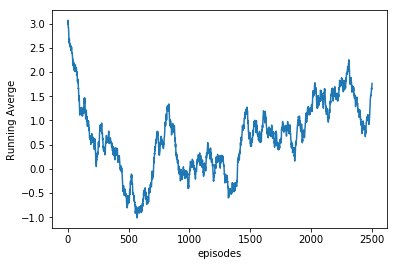

[2018-07-10 22:05:59,779] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/pong')


In [5]:
with tf.Session() as sess:
    agent.set_session(sess)
    sess.run(tf.global_variables_initializer())
    agent.load()
    # training loop
    done = False
    while not done and n< num_episodes:
        # Preprocess the observation
        cur_state = preprocess(obs)
        diff_state = cur_state - prev_state if prev_state is not None else np.zeros(n_size*n_size)
        prev_state = cur_state

        #Predict the action
        aprob = agent.predict_UP(diff_state) ; aprob = aprob[0,:]


        action = np.random.choice(n_actions, p=aprob)
        #print(action)
        label = np.zeros_like(aprob) ; label[action] = 1

        # Step the environment and get new measurements
        obs, reward, done, info = env.step(action)
        env.render()
        reward_sum += reward

        # record game history
        states.append(diff_state) ; labels.append(label) ; rewards.append(reward)

        if done:
            # update running reward
            running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
            running_rewards.append(running_reward)
            #print(np.vstack(rs).shape)
            feed = {agent.tf_x: np.vstack(states), agent.tf_epr: np.vstack(rewards), agent.tf_y: np.vstack(labels)}
            agent.update(feed)
            # print progress console
            if n % 10 == 0:
                print ('ep {}: reward: {}, mean reward: {:3f}'.format(n, reward_sum, running_reward))
            else:
                print ('\tep {}: reward: {}'.format(n, reward_sum))

            # Start next episode and save model
            states, rewards, labels = [], [], []
            obs = env.reset()
            n += 1 # the Next Episode

            reward_sum = 0
            if n % 50 == 0:
                agent.save()
            done = False

plt.plot(running_rewards)
plt.xlabel('episodes')
plt.ylabel('Running Averge')
plt.show()
env.close()


In [11]:
from gym import wrappers
env = gym.envs.make(env_name)
env = wrappers.Monitor(env, 'save-mov',force=True)
with tf.Session() as sess:
    
    agent.set_session(sess)
    sess.run(tf.global_variables_initializer())
    agent.load()
    
    obs = env.reset()
    cur_state = preprocess(obs)
    

    done = False
    while not done:
        diff_state = cur_state - prev_state if prev_state is not None else np.zeros(n_size*n_size)
        prev_state = cur_state
        aprob = agent.predict_UP(diff_state) ; aprob = aprob[0,:]
        action = np.argmax(aprob)
        #print(action)
        obs, reward, done, _ = env.step(action)
        env.render()
        cur_state = preprocess(obs)
        
env.close()

[2018-07-10 22:18:14,115] Making new env: Pong-v0
[2018-07-10 22:18:14,268] Clearing 4 monitor files from previous run (because force=True was provided)


models1/pong.ckpt-2500
INFO:tensorflow:Restoring parameters from models1/pong.ckpt-2500


[2018-07-10 22:18:14,368] Restoring parameters from models1/pong.ckpt-2500
[2018-07-10 22:18:14,418] Starting new video recorder writing to /home/am/Dropbox/AIforIoT/Chapter06/save-mov/openaigym.video.6.24686.video000000.mp4


loaded model: models1/pong.ckpt-2500


[2018-07-10 22:18:26,865] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/am/Dropbox/AIforIoT/Chapter06/save-mov')
